Missing values per column:
 Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
price         0
x             0
y             0
z             0
dtype: int64

Dataset Summary:
          Unnamed: 0         carat         depth         table         price  \
count  53940.000000  53940.000000  53940.000000  53940.000000  53940.000000   
mean   26970.500000      0.797940     61.749405     57.457184   3932.799722   
std    15571.281097      0.474011      1.432621      2.234491   3989.439738   
min        1.000000      0.200000     43.000000     43.000000    326.000000   
25%    13485.750000      0.400000     61.000000     56.000000    950.000000   
50%    26970.500000      0.700000     61.800000     57.000000   2401.000000   
75%    40455.250000      1.040000     62.500000     59.000000   5324.250000   
max    53940.000000      5.010000     79.000000     95.000000  18823.000000   

                  x             y             z  
co

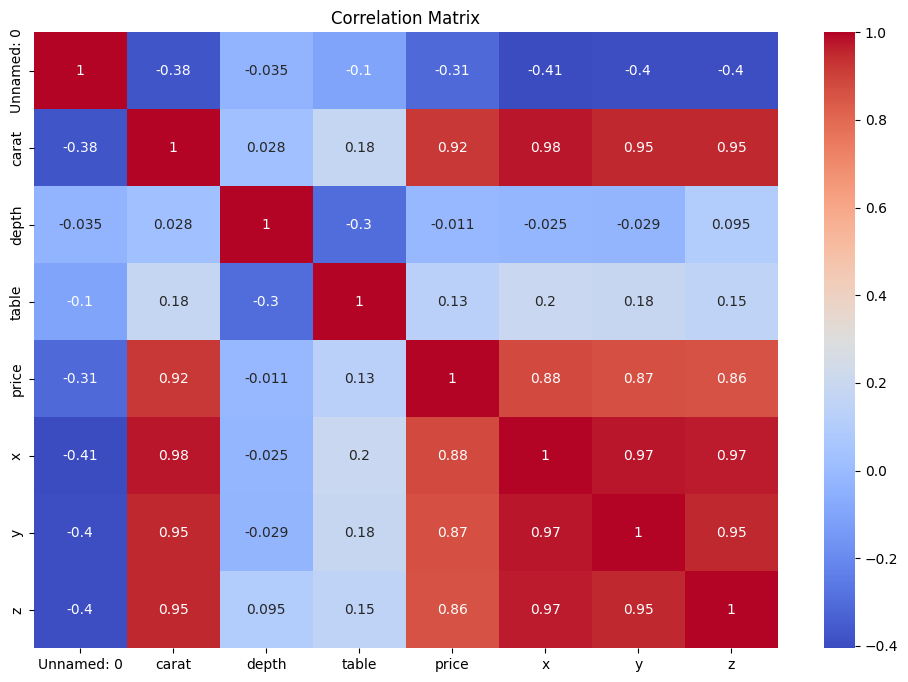

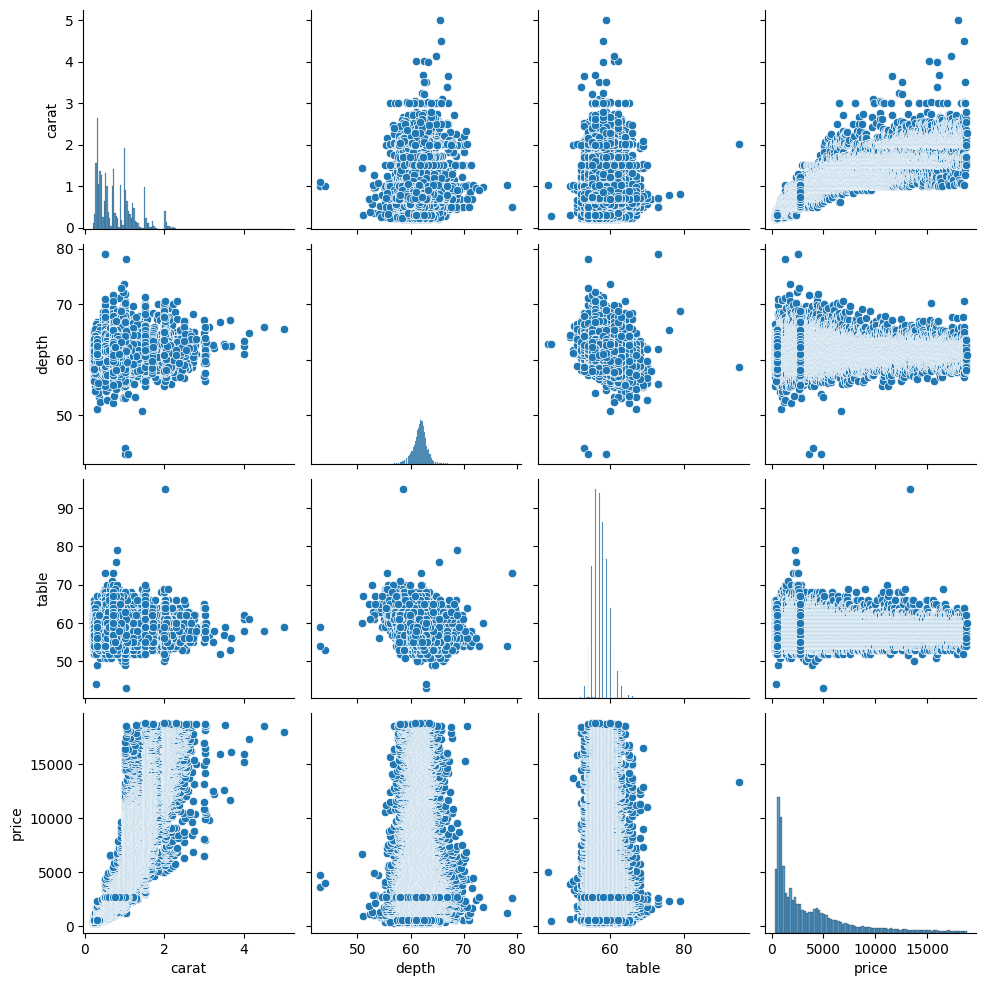

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.717e+10, tolerance: 5.065e+07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.721e+10, tolerance: 5.046e+07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.704e+10, tolerance: 5.037e


Model Comparison:
                    Model  CV R2 Mean   Test R2    Test RMSE
1  Polynomial Regression    0.973023  0.974268   621.788364
0      Linear Regression    0.928215  0.927965  1040.355713
2       Ridge Regression    0.928231  0.927956  1040.419966
3       Lasso Regression    0.928308  0.927918  1040.695195
4             ElasticNet    0.925330  0.924474  1065.265483

Top 10 Linear Regression Coefficients:
         Feature  Coefficient
0          carat  6166.774048
4              y  1576.783281
19    clarity_IF  1424.855570
24  clarity_VVS1  1069.768866
25  clarity_VVS2  1019.269331
11       color_D   860.107434
22   clarity_VS1   690.886136
12       color_E   639.000722
13       color_F   562.094286
23   clarity_VS2   368.524141


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore
from sklearn.impute import SimpleImputer

df = pd.read_csv('diamonds.csv')

print("Missing values per column:\n", df.isnull().sum())
print("\nDataset Summary:\n", df.describe())

# correlations with heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# relationships
sns.pairplot(df[['carat', 'depth', 'table', 'price']])
plt.show()

# remove rows with feature more than 3 standard deviations from mean
num_cols = ['carat', 'depth', 'table', 'x', 'y', 'z']
df = df[(np.abs(zscore(df[num_cols])) < 3).all(axis=1)]

# columns are numerical and categorical
cat_feats = ['cut', 'color', 'clarity']
num_feats = ['carat', 'depth', 'table', 'x', 'y', 'z']

# imputing missing values using mean, then standardize
num_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# imputing missing values using most frequent value, then one-hot encode
cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# combine pipelines into preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipe, num_feats),
    ('cat', cat_pipe, cat_feats)
])

# dictionary of models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Polynomial Regression': Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('regressor', LinearRegression())
    ]),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.01),
    'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5)
}

X = df.drop('price', axis=1)
y = df['price']

# split training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = []

# evaluate each model using cross-validation and test set metrics
for name, model in models.items():
    # create pipeline that first preprocesses the data then applies the model
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # cross-validation using R^2 scoring metric
    cv_score = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2').mean()

    # Fit training set and predict on test set
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    # Append results
    results.append({
        'Model': name,
        'CV R2 Mean': cv_score,
        'Test R2': r2_score(y_test, y_pred),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    })

# compare model performances
results_df = pd.DataFrame(results)
print("\nModel Comparison:\n", results_df.sort_values(by='Test R2', ascending=False))

# fit Linear Regression model
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
lr_pipeline.fit(X_train, y_train)

# retrieve one-hot encoded feature names from the categorical transformer
cat_feature_names = lr_pipeline.named_steps['preprocessor']\
    .named_transformers_['cat']\
    .named_steps['encoder']\
    .get_feature_names_out(cat_feats)
all_features = num_feats + list(cat_feature_names)

# dataFrame for the coefficients
coeffs = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': lr_pipeline.named_steps['model'].coef_
}).sort_values(by='Coefficient', ascending=False)

print("\nTop 10 Linear Regression Coefficients:")
print(coeffs.head(10))
